# homework 13: the Moriarty Brain Atlas
* Eric Yang
* 12/05/20

Goal: Visualize RNA Seq data via t-SNE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
import scipy 

## 1. verify that PCA fails

As explained by Moriarty, the hypercube structure masks many of the data when using a rigid rotation technique like PCA. Let's reproduce Moriarty's result and see that PCA doesn't cluster well with his data.

In [2]:
# load data
small = pd.read_csv('w13-data-small.tbl', sep="\t")
large = pd.read_csv('w13-data-large.tbl', sep="\t")

# get classes
small_class = small['type']
large_class = large['type']

# remove classes from datasets
small = small.drop(columns=["type"]).to_numpy()
large = large.drop(columns=["type"]).to_numpy()

# add 1 to prevent logging count = 0, then log and center counts
small_log = np.log(np.add(1, small))
small_c = small_log - np.mean(small_log, axis=0)
large_log = np.log(np.add(1, large))
large_c = large_log - np.mean(large_log, axis=0)

# get dim
ns,ps  = small.shape
nl,pl  = large.shape

In [3]:
# run PCA on small data set, PCA and plotting code adapted from Professor Eddy's "w11-answeres=SRE" notebook   
# SVD method
U, S, Wt = np.linalg.svd(small_c)
W        = np.transpose(Wt)
eigvals  = [ S[i]*S[i] / (ps-1) for i in range(ps)]
X2       = (small_c @ W)[:,:2]                          # X2 is now our data, n x 2, projected onto the first two PCs.

Text(0, 0.5, 'PC2')

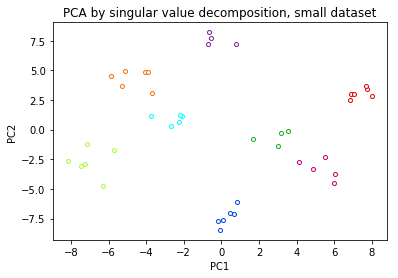

In [4]:
# plot PC1 vs PC2
Color = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]


fig1, ax1 = plt.subplots()
for i in range(ns):
    ax1.plot(X2[i,0], X2[i,1], 'o', markersize=4, mfc='4', mec=Color[small_class[i]%8])
ax1.set_title('PCA by singular value decomposition, small dataset')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

It looks like the small dataset clusters okay, not great. there are definitely some clusters that overlap due to the hypercube structure. Let's see how it does with the large data set with 16 cell types.

In [ ]:
# run PCA on large data set   
# SVD method
U, S, Wt = np.linalg.svd(large_c)
W        = np.transpose(Wt)
eigvals  = [ S[i]*S[i] / (pl-1) for i in range(pl)]
X2       = (large_c @ W)[:,:2]                          # X2 is now our data, n x 2, projected onto the first two PCs.

Text(0, 0.5, 'PC2')

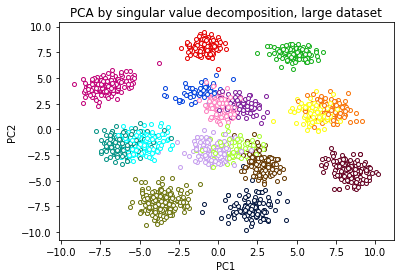

In [ ]:
# plot PC1 vs PC2
fig2, ax2 = plt.subplots()
for i in range(nl):
    ax2.plot(X2[i,0], X2[i,1], 'o', markersize=4, mfc='4', mec=Color[large_class[i]%16])
ax2.set_title('PCA by singular value decomposition, large dataset')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

As expected, it's difficult to visualize large data set's projection onto the first 2 PCs. Perhaps a nonlinear projection would do better...

## 2. implement t-SNE for yourself

In [ ]:
# precompute distance matrix
def calculate_dist(X):
    # given data matrix X (n cells by m genes), calculate euclidean distance between each cell
    ns = X.shape[0]
    Dij = np.zeros([ns,ns])
    for cell in range(ns):
        for neighbor in range(ns):
            Dij[cell][neighbor] = np.linalg.norm(X[cell] - X[neighbor])
    return Dij

# check diag of dist matrix is 0, since it refers to same cell
D = calculate_dist(small_c)
assert np.diag(D).all() == 0

In [ ]:
# optimize sigma for each point
def perplexity_diff(sigma_i, D_i, perplexity_true): 
    # handle D_ii case
    D_i = D_i[D_i != 0]
    # calculate p_ji
    numerator = np.exp(-(D_i**2)/(2*(sigma_i**2)))
    # normalize p_ji
    p_i = numerator/(np.sum(numerator))
    # calculate entropy
    H_i = -np.sum(p_i * np.log2(p_i))
    # calculate perplexity
    perp_est = 2 ** H_i
    # calculate diff
    diff = perp_est - perplexity_true
    return diff

In [ ]:
# bisection search to find sigma for each point
def bisect_search(perp_true, D):
    # given distance matrix and target perplexity, calculate sigmas that satisfy perplexity
    # criteria for each cell(point) using bisection search
    ns = D.shape[0]
    sigmas = np.zeros(ns)
    for cell in range(ns):
        # find initial bounds
        a = 1
        while perplexity_diff(a, D[cell], perp_true) >= 0:
            a /= 2
        b = 1
        while perplexity_diff(b, D[cell], perp_true) <= 0:
            b *= 2
        sig = scipy.optimize.bisect(perplexity_diff, a, b, args = (D[cell].flatten(),perp_true))
        sigmas[cell] = sig
    return sigmas

# test out bisect_search algorithm with true_perp = 8
sigmas = bisect_search(5, D)

In [ ]:
# calculate p_ji
def calculate_conditional(sigma, D):
    # given distance matrix and sigmas, calculate "probability of visiting each neighbor" for each cell
    ns, ps = np.shape(D)
    p_ji = np.zeros([ns,ns])
    for cell in range(ns):
        numerator = np.exp(-D[cell]**2 / (2*sigma[cell]**2))
        row = numerator/(np.sum(numerator)-1) # subtract 1 to handle p_ii case since exp(0) = 1
        p_ji[cell] = row
    np.fill_diagonal(p_ji,0)
    return p_ji

In [ ]:
# calculate final symmetric prob distribution
def calculate_pij(sigmas,D):
    # converts conditionals to a symmetric joint prob 
    ns = D.shape[0]
    p_ji = calculate_conditional(sigmas,D)
    pij = (p_ji + p_ji.T)/(2*ns)
    return pij

In [ ]:
# KL divergence, relationship between P and Q
def KL_dist(Y, Pij):
    # given Y (tSNE coords) and joint probabilities, calculate KL divergence between P and Q
    ns = int(len(Y)/2)
    Y = np.reshape(Y,[ns,2])
    Y_dist = calculate_dist(Y)
    # calculate qij and gradient simultaneously
    q = np.zeros([ns,ns])
    gradient = np.zeros([ns,2])
    denom = np.sum(1/(1+Y_dist**2))
    for i in range(ns):
        grad = 0
        for j in range(ns):
            q[i][j] = (1/(1+Y_dist[i][j]**2))/denom
            grad += (Pij[i][j]-q[i][j]) * (Y[i]-Y[j]) * (1/(1+Y_dist[i][j]**2))
        gradient[i] = 4 * grad
    KL = Pij*np.log(Pij/q)
    np.fill_diagonal(KL,0)
    KL = np.sum(KL)
    return KL, gradient.flatten()

In [ ]:
def tSNE(perp_true, data):
    # combining it all together, given target perplexity and data, returns tSNE1 and 2 coords
    D = calculate_dist(small_c)
    sigmas = bisect_search(perp_true, D)
    pij = calculate_pij(sigmas,D)
    
    best_KL = 1e99
    best_Y = np.zeros([ns,2])
    for i in range(5): # try different initializations
        # initialize Y
        mu = 0
        sigma = 1e-4
        np.random.seed(i)
        Y_init = np.random.normal(mu, sigma, (len(small_c),2))
        Y = scipy.optimize.minimize(KL_dist, Y_init.flatten(), args=(pij), jac=True)
        if Y.fun < best_KL:
            best_KL = Y.fun
            best_Y = Y.x
    return best_Y

Warning: below takes awhile to run

/Users/ericyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/ericyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'tSNE2')

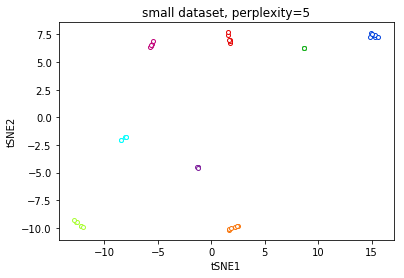

In [ ]:
# try target perplexity = 5
result_5 = tSNE(5, small_c)
Y_est = np.reshape(result_5,[ns,2])
for j in range(ns):
    plt.plot(Y_est[j,0], Y_est[j,1], 'o', markersize=4, mfc='4', mec=Color[small_class[j]%8])
plt.title("small dataset, perplexity=5")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Seems like t-SNE is working! Because of its nonlinear transformation, t-SNE is better able to cluster Moriarty's "hypercube data". I arbitrarily chose target perplexity = 5 here, essentially considering 5 effective neighbors. This seems to work well given our sample size of 42 and 8 cell types, approximately 5 cells per type. Let's see what happens when we bump the target perplexity up to 30.

/Users/ericyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/ericyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'tSNE2')

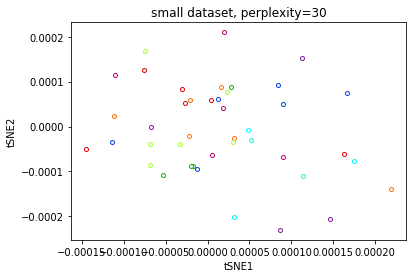

In [ ]:
# try target perplexity = 30
result_30 = tSNE(30, small_c)
Y_est = np.reshape(result_30,[ns,2])
for j in range(ns):
    plt.plot(Y_est[j,0], Y_est[j,1], 'o', markersize=4, mfc='4', mec=Color[small_class[j]%8])
plt.title("small dataset, perplexity=30")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Indeed, tSNE fails to cluster the small dataset with target perplexity of 30. We have 42 cells and 8 cell types here and considering 30 effective neighbors gives too much similarity between truly unrelated cells. We won't run our tSNE implementation on the large data set here since the global optimum problem become more pronounced with more data points.

## 3. using the canned t-SNE from scikit

Let's compare our results to scikit-learn's t-SNE implementation

Warning: below takes awhile to run

In [ ]:
# run tSNE for both small and large dataset using perplexity values of 2, 5, 30, 100 and plot
perps = [2, 5, 30, 100, 2, 5, 30, 100]
np.random.seed(5)
f = plt.figure(figsize=(16,8))
for i, perp in enumerate(perps):
    ax = f.add_subplot(2,4,i+1)
    
    # determine dataset to use
    if i < 4:
        data = small_c
        lab = "small"
        assignments = small_class
        classes = 8
        n = ns
    else:
        data = large_c
        lab = "large"
        assignments = large_class
        classes = 16
        n = nl
        
    # run tSNE
    Y = TSNE(perplexity=perp).fit_transform(data)
    
    # plot
    for j in range(n):
        ax.plot(Y[j,0], Y[j,1], 'o', markersize=4, mfc='4', mec=Color[assignments[j]%classes])
    ax.set_title(lab + ' dataset, perp = ' + str(perp))
    ax.set_xlabel('tSNE1')
    ax.set_ylabel('tSNE2')
f.tight_layout(pad=1.0)

While we don't see an exact match between our tSNE implementation and scikit-learn's due to their optimization for global clustering, we do see similar trends to verify our intuition. For the small dataset, a target perplexity of 5 clusters well in both implementations and a target perplexity of 30 does not do well, as explained in part 2. We see the reverse for the large dataset, with 2119 cells and 16 different cell types. Considering only 2 effective neighbors with this data limits tSNE's ability to effectively compare differences with all other cells. As we increase the target perplexity for the large data set, the clusters become more and more apparent. Finding the sweet spot is an art in itself!